In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from salad.models.phase1 import Phase1Model
from salad.models.phase2 import Phase2Model
from salad.models.language_phase1 import LangPhase1Model
from salad.models.language_phase2 import LangPhase2Model
from omegaconf import OmegaConf
import hydra
from salad.model_components.network import UnCondDiffNetwork, CondDiffNetwork
from salad.utils import visutil, imageutil
from salad.utils.spaghetti_util import *
from typing import Literal
from pytorch_lightning import seed_everything
device = "cuda:1"

def load_model(model_class: Literal["phase1", "phase2", "lang_phase1", "lang_phase2"], device):
    c = OmegaConf.load(f"../checkpoints/chair/{model_class}/hparams.yaml")
    model = hydra.utils.instantiate(c)
    ckpt = torch.load(f"../checkpoints/chair/{model_class}/state_only.ckpt")
    model.load_state_dict(ckpt)
    model.eval()
    for p in model.parameters(): p.requires_grad_(False)
    model = model.to(device)
    return model

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Modified Open3D __init__.py to disable loading unnecessary module 'open3d.ml'!


# Load SPAGHETTI and Mesher

In [4]:
spaghetti = load_spaghetti(device=device)
mesher = load_mesher(device=device)

loading spaghetti model from /home/dreamy1534/Projects/eccv2024/SALAD/salad/spaghetti/assets/checkpoints/spaghetti_chairs_large/model


# Load models

In [10]:
phase1_model = load_model("phase1", device)
phase2_model = load_model("phase2", device)
p1_val_dset = phase1_model._build_dataset("val")
p2_val_dset = phase2_model._build_dataset("val")
assert len(p1_val_dset) == len(p2_val_dset), f"{len(p1_val_dset)} != {len(p2_val_dset)}"

# Part Name Lookup Table

In [62]:
PART_TABLE = {
    # Manually found semantic labels for parts
    "back": [2, 10, 6, 14, 7, 15],
    "seat": [5, 13, 3, 11],
    "front_leg": [0, 1, 8, 9],
    "hind_leg": [4, 12],
    "arm": [4, 12],

    # Complements of semantic parts
    "back_compl": [0, 1, 3, 4, 5, 8, 9, 11, 12, 13],
    "seat_compl": [0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 14],
    "front_leg_compl": [2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14],
    "hind_leg_compl": [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14],
    "arm_compl": [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14],
}

tgt_name = "back"

# Ablate Gaussians

In [63]:
seed_everything(63)

idx = 10  # Select one sample

intrinsics, extrinsics = p2_val_dset[idx]
intrinsics = intrinsics.to(device)[None, ...]
extrinsics = extrinsics.to(device)[None, ...]
zcs = generate_zc_from_sj_gaus(spaghetti, intrinsics, extrinsics)

Global seed set to 63


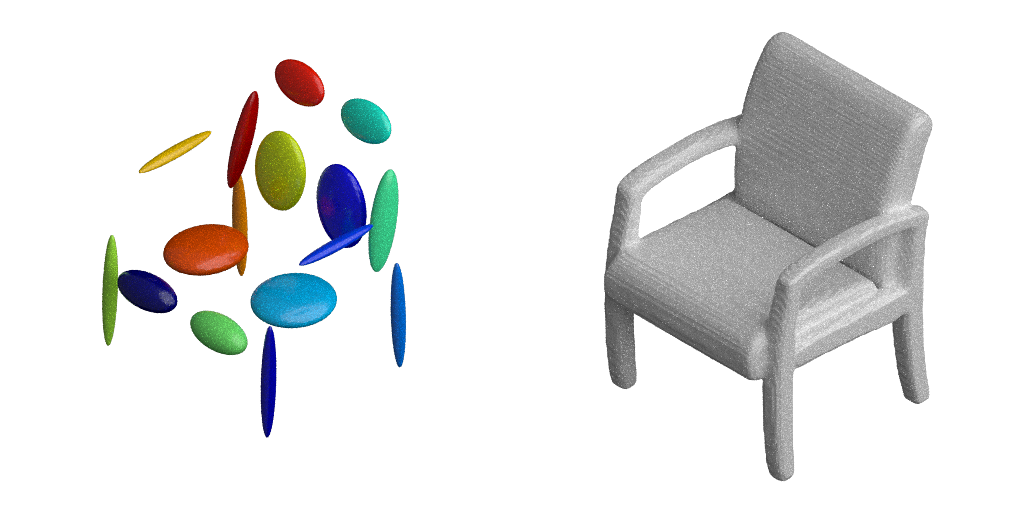

In [64]:
# Visualize the selected sample
images = []
for i in range(len(zcs)):
    gaus_img = visutil.render_gaussians(extrinsics[i])
    
    v, f = get_mesh_from_spaghetti(spaghetti, mesher, zcs[i], res=256)
    mesh_img = visutil.render_mesh(v, f)
    
    img = imageutil.merge_images([gaus_img, mesh_img])
    display(img)

torch.Size([1, 10, 512]) torch.Size([1, 10, 16])


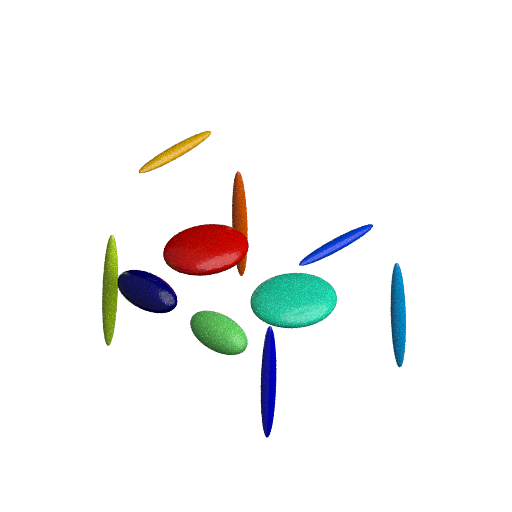

In [65]:
# Ablate some parts
tgt_parts = torch.tensor(PART_TABLE[tgt_name], device=device)

intrinsics_ = [intrinsics[:, i] for i in range(intrinsics.shape[1]) if i not in tgt_parts]
intrinsics_ = torch.stack(intrinsics_, dim=1)
extrinsics_ = [extrinsics[:, i] for i in range(extrinsics.shape[1]) if i not in tgt_parts]
extrinsics_ = torch.stack(extrinsics_, dim=1)
print(intrinsics_.shape, extrinsics_.shape)

for i in range(len(extrinsics_)):
    gaus_img = visutil.render_gaussians(extrinsics_[i])
    display(gaus_img)

In [67]:
# Define helper functions
def denoise_one_step(model, x, t):
    assert x.ndim == 3, f"Expected 'x' to have 3 dimensions, got {x.ndim}"

    batch_size = x.size(0)

    z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
    alpha = model.var_sched.alphas[t]
    alpha_bar = model.var_sched.alpha_bars[t]
    sigma = model.var_sched.get_sigmas(t, flexibility=0)

    c0 = 1.0 / torch.sqrt(alpha)
    c1 = (1 - alpha) / torch.sqrt(1 - alpha_bar)

    beta = model.var_sched.betas[[t] * batch_size]
    e_theta = model.net(x, beta=beta)
    # print(e_theta.norm(-1).mean())

    x_next = c0 * (x - c1 * e_theta) + sigma * z

    return x_next

def create_mask(
    part_repr: torch.Tensor,
    tgt_parts: torch.Tensor,
    n_variation: int,
):
    """
    Args:
        part_repr: (N, D) where N is the number of parts.
        part_label: (N,) where N is the number of parts.
        n_variation: Number of variation made for each part.

    Returns:
        masks: (N * n_variation, N, D). Binary mask indicating the parts to be modified
            during denoising process.
    """
    assert isinstance(part_repr, torch.Tensor)
    assert isinstance(tgt_parts, torch.Tensor)
    assert part_repr.ndim == 2, f"{part_repr.ndim}"
    assert tgt_parts.ndim == 1, f"{tgt_parts.ndim}"
    # assert part_repr.size(0) == tgt_parts.size(0), f"{part_repr.size(0)} != {tgt_parts.size(0)}"
    assert isinstance(n_variation, int) and n_variation > 0

    masks = torch.zeros_like(part_repr)
    for idx in tgt_parts:
        masks[idx, ...] = 1.0

    return masks

@torch.no_grad()
def loop_sdedit_uncond(
    model, 
    gmms: torch.Tensor, 
    part_labels: torch.Tensor, 
    n_variation_per_part: int,
    start_t: int,
):
    """
    A helper function for SDEdit that loops over the shapes in the dataset.

    This function is used to edit latents using unconditional diffusion models.
    """
    assert isinstance(gmms, torch.Tensor)
    assert isinstance(part_labels, torch.Tensor)
    assert isinstance(n_variation_per_part, int) and n_variation_per_part > 0
    assert isinstance(start_t, int) and start_t > 0
    assert gmms.size(0) == part_labels.size(0), f"{gmms.size(0)} != {part_labels.size(0)}"

    # iterate over shapes, make variations
    splits = [0]
    gmm_variations = []
    masks = []
    for (gmm, part_label) in zip(gmms, part_labels):
        mask = create_mask(gmm, part_label, n_variation_per_part)
        n_mask = mask.size(0)

        gmm_to_edit = gmm[None].clone().repeat(n_mask, 1, 1)
        gmm_variation = sdedit_gmms(model, gmm_to_edit, mask, start_t, verbose=False)

        splits.append(n_mask)
        gmm_variations.append(gmm_variation)
        masks.append(mask)

    splits = torch.cumsum(torch.tensor(splits), 0)
    gmm_variations = torch.cat(gmm_variations, 0)
    masks = torch.cat(masks, 0)

    return gmm_variations, splits, masks

@torch.no_grad()
def sdedit_gmms(
    model,
    gmms,
    masks,
    start_t,
    verbose=True,
):
    """
    Performs shape completion given incomplete sets of GMMs.

    Args:
        model:
        part_repr: (B, N, D). A batch of part-wise representations to be modified
        masks: (B, N, D). A batch of binary masks indicating the parts to be modified.
        start_t: The timestep where denoising process starts.
        method: 
        verbose:
    """
    assert start_t >= 0 and start_t <= model.var_sched.num_steps
    assert gmms.ndim == 3, f"Got 'gmms' of dimension {gmms.ndim}"
    assert gmms.shape == masks.shape, f"{gmms.shape} != {masks.shape}"

    timesteps = list(range(start_t, 0, -1))
    x0 = gmms.clone()

    # Process input if additional steps are required
    use_scaled_eigvec = model.hparams.get("use_scaled_eigenvectors")
    if use_scaled_eigvec:
        raise NotImplementedError("Use of scaled Gaussians is not supported yet")

    normalize_method = model.hparams.get("global_normalization")
    if normalize_method is not None:
        if not hasattr(model, "data_val"):
            model._build_dataset("val")
            if verbose:
                print(
                    "[*] Loaded statistics for Gaussians since the model was trained on normalized data"
                )

        if normalize_method == "partial":
            x0 = model.data_val.normalize_global_static(x0.detach().cpu().numpy(), slice(12, None))           
        elif normalize_method == "all":
            x0 = model.data_val.normalize_global_static(x0.detach().cpu().numpy(), slice(None))
        else:
            raise NotImplementedError(
                f"Encountered unknown normalization method: {str(normalize_method)}"
            )
        x0 = torch.from_numpy(x0).to(gmms.device)
        assert gmms.shape == x0.shape, (
            f"Shape of a tensor must not change during preprocessing, got {gmms.shape} and {x0.shape}"
        )

    x, _, _ = model.add_noise(x0, start_t)

    for t in timesteps:
        with torch.no_grad():
            x_ = denoise_one_step(model, x, t)            
        ####
        # x = add_noise(model, x0, t - 1)
        x, _, _ = model.add_noise(x0, t - 1)
        ####
        x[masks == 1.0] = x_[masks == 1.0]
    assert x.shape == gmms.shape, f"'x' shape: {x.shape} / 'gmms' shape: {gmms.shape}"
    assert torch.all(x[masks == 0.0] == x0[masks == 0.0]), (
        "The algorithm must not edit the unmasked parts"
    )

    # if necessary, unnormalized the data
    if normalize_method is not None:
        if normalize_method == "partial":
            x = model.data_val.unnormalize_global_static(x, slice(12, None))
        elif normalize_method == "all":
            x = model.data_val.unnormalize_global_static(x, slice(None))
        else:
            raise NotImplementedError(
                f"Encountered unknown normalization method: {str(normalize_method)}"
            )
        x = torch.from_numpy(x).to(gmms.device)
    
    # apply projection and clipping
    x = project_eigenvectors(clip_eigenvalues(x)).to(x0.device)
    
    return x

In [57]:
# Run SDEdit for Phase 1
mask = create_mask(extrinsics[0], tgt_parts, 1)[None, ...]
ext_edit = sdedit_gmms(
    phase1_model, extrinsics, mask, start_t=250
)

torch.Size([1, 16, 16])


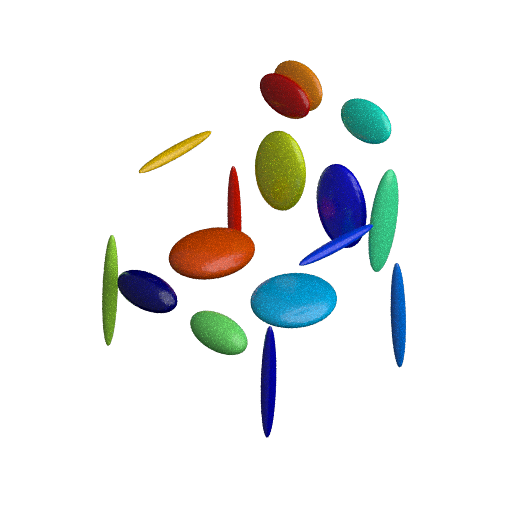

In [58]:
# Visualize the completed Gaussians
for i in range(len(ext_edit)):
    gaus_img = visutil.render_gaussians(ext_edit[i])
    display(gaus_img)

In [60]:
# Run sampling for Phase 2
int_edit = phase2_model.sample(ext_edit)
zc_edit = generate_zc_from_sj_gaus(spaghetti, int_edit, ext_edit)

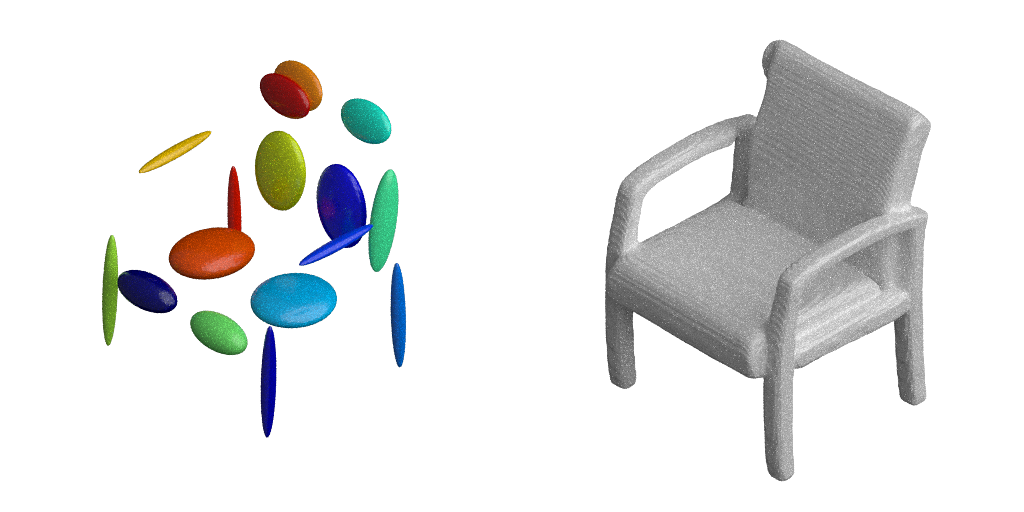

In [61]:
# visualize
images = []
for i in range(len(zc_edit)):
    gaus_img = visutil.render_gaussians(ext_edit[i])
    
    v, f = get_mesh_from_spaghetti(spaghetti, mesher, zc_edit[i], res=256)
    mesh_img = visutil.render_mesh(v, f)
    
    img = imageutil.merge_images([gaus_img, mesh_img])
    display(img)